# Overview
## EM / Gaussian Mixture clustering on Plant Health Data

Steps:
1. Load the dataset and preprocess features
2. Apply wavelet-based feature extraction + PCA
3. Fit Gaussian Mixture Models for different numbers of clusters
4. Select the best number of clusters using Silhoutte score
5. Visualize the final clustering in PCA space

## Loading Data + Imports

In [1]:
import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing import preprocess, get_labels

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [2]:
df = pd.read_csv("../../data/plant_health_data.csv")
df

,Timestamp,Plant_ID,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal,Plant_Health_Status
0,2024-10-03 10:54:53.407995,1,27.521109,22.240245,21.900435,55.291904,556.172805,5.581955,10.003650,45.806852,39.076199,35.703006,0.941402,High Stress
1,2024-10-03 16:54:53.407995,1,14.835566,21.706763,18.680892,63.949181,596.136721,7.135705,30.712562,25.394393,17.944826,27.993296,0.164899,High Stress
2,2024-10-03 22:54:53.407995,1,17.086362,21.180946,15.392939,67.837956,591.124627,5.656852,29.337002,27.573892,35.706530,43.646308,1.081728,High Stress
3,2024-10-04 04:54:53.407995,1,15.336156,22.593302,22.778394,58.190811,241.412476,5.584523,16.966621,26.180705,26.257746,37.838095,1.186088,High Stress
4,2024-10-04 10:54:53.407995,1,39.822216,28.929001,18.100937,63.772036,444.493830,5.919707,10.944961,37.898907,37.654483,48.265812,1.609805,High Stress
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2024-11-01 04:54:53.493508,10,29.665780,27.605285,15.381699,54.668196,650.536854,5.715289,29.993107,14.914470,21.560747,24.273224,0.714553,Moderate Stress
1196,2024-11-01 10:54:53.493508,10,15.490782,22.108112,15.221033,61.243143,768.760787,5.958957,45.258678,25.216248,31.940717,30.930676,1.448029,High Stress
1197,2024-11-01 16:54:53.493508,10,23.495723,21.680240,15.499764,40.693671,293.643366,7.419157,38.351189,48.656078,28.473233,38.324484,0.880019,Moderate Stress
1198,2024-11-01 22:54:53.493508,10,30.971675,23.019488,21.934918,41.387107,492.952014,5.855767,49.402550,23.843971,19.750042,46.027529,0.344597,Healthy


## Using our preprocessing pipeline to clean + normalize data

In [3]:
cleaned = preprocess(df, attr=[])
cleaned.head()

,Soil_Moisture,Ambient_Temperature,Soil_Temperature,Humidity,Light_Intensity,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Chlorophyll_Content,Electrochemical_Signal
Timestamp,,,,,,,,,,,
2024-10-03 10:54:53.407995,0.278321,-0.511285,0.662825,0.049963,-0.247408,-1.620166,-1.746638,1.355983,0.768579,0.108796,-0.080646
2024-10-03 16:54:53.407995,-1.184139,-0.666361,-0.435676,1.035845,-0.072300,1.051744,0.052635,-0.424888,-1.043216,-0.770972,-1.431377
2024-10-03 22:54:53.407995,-0.924655,-0.819209,-1.557519,1.478694,-0.094261,-1.491368,-0.066879,-0.234739,0.479665,1.015220,0.163452
2024-10-04 04:54:53.407995,-1.126428,-0.408656,0.962382,0.380088,-1.626583,-1.615750,-1.141667,-0.356286,-0.330470,0.352435,0.344986
2024-10-04 10:54:53.407995,1.696462,1.433049,-0.633556,1.015672,-0.736748,-1.039349,-1.664853,0.666060,0.646682,1.542359,1.082045


### Feature Matrix for Clustering

We use the cleaned sensor features directly for clustering, and later apply PCA(2) only for visualization.

In [4]:
# Full feature space used for clustering
X = cleaned.copy()
X.head()

# 2D PCA only for plotting
pca_2d = PCA(n_components=2, random_state=0)
X_2d = pca_2d.fit_transform(X)
pca_points = pd.DataFrame(X_2d, columns=["PC0", "PC1"], index=X.index)

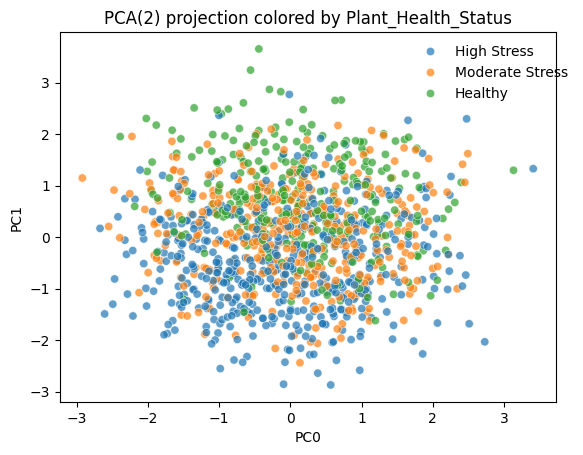

In [5]:
labels = get_labels(df)
points = pca_points.copy()
points["y"] = labels.values.ravel()

sns.scatterplot(data=points, x="PC0", y="PC1", hue="y", alpha=0.7)
plt.title("PCA(2) projection colored by Plant_Health_Status")
plt.legend(bbox_to_anchor=(1.05, 1), frameon=False)
plt.show()

## EM / Gaussian Mixture Modeling

We fit Gaussian Mixture Model with different numbers of components "k" and evaluate them using Davies Bouldin and Silhouette score

In [6]:
Ks = list(range(2,21))
db_scores = []
sil_scores = []

for k in Ks:
    # I tried many different params, but this gave the highest Silhouette score values out of all trials
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        init_params="kmeans",
        random_state=0
    )
    gmm.fit(X)

    labels_k = gmm.predict(X)

    db_scores.append(davies_bouldin_score(X, labels_k))

    if len(np.unique(labels_k)) > 1:
        sil = silhouette_score(X, labels_k)
    else:
        sil = np.nan
    sil_scores.append(sil)

db_scores, sil_scores, Ks

([3.6658170522784643,
  3.4958758646446206,
  3.3490779447417114,
  3.145480074972216,
  3.073970486446534,
  2.9551020721836707,
  3.2415684652602383,
  2.924698075699354,
  2.864908443018689,
  2.774734712104012,
  2.8751021452049894,
  2.7759381044463747,
  2.663298925889493,
  2.567584174338424,
  2.487844741135712,
  2.623972402651082,
  2.481971632395311,
  2.53578307308781,
  2.428321566463615],
 [0.06685180340978912,
  0.05209675369126465,
  0.05587657297651866,
  0.0471104719091742,
  0.04576534028881138,
  0.034177506748900195,
  0.02703368015196761,
  0.0290260566413782,
  0.028064719356971277,
  0.028193012535028088,
  0.02955559693974278,
  0.029352569604611602,
  0.03568091119465433,
  0.03813453595919875,
  0.03780862724401736,
  0.029826975121817555,
  0.03244804343333904,
  0.02856213228078429,
  0.03743703947272144],
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

## Visualization of the Davies Bouldin and Silhouette Scores

Below we can see the visualization of the scores we got for each k value. For Davies Bouldin, a smaller value is better, and for Silhouette a higher score is better

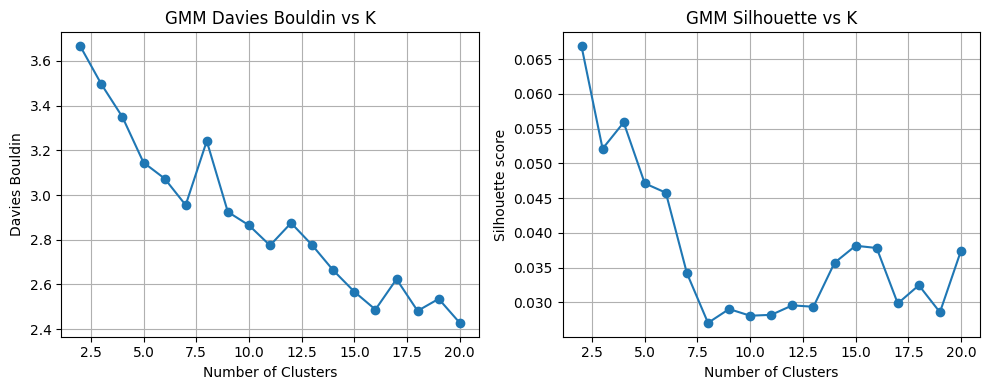

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Davies Bouldin (lower is better)
ax[0].plot(Ks, db_scores, "-o")
ax[0].set_xlabel("Number of Clusters")
ax[0].set_ylabel("Davies Bouldin")
ax[0].set_title("GMM Davies Bouldin vs K")
ax[0].grid(True)

# Silhouette (higher is better)
ax[1].plot(Ks, sil_scores, "-o")
ax[1].set_xlabel("Number of Clusters")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("GMM Silhouette vs K")
ax[1].grid(True)

plt.tight_layout()
plt.show()

The above plots show the Davies Bouldin, and Silhouette score values we get from k=2 to k=20 clusters. Looking at the Silhouette scores, overall we can see very low scores. This indicates

For Davies Bouldin, a lower score is optimal. We see a global minimum at k=15, which is also a local maximum for the Silhouette scores. So I will visualize k=15 clusters.

In [8]:
best_K=15

In [9]:
final_gmm = GaussianMixture(
    n_components=best_K,
    covariance_type="full",
    random_state=0
)
final_gmm.fit(X)
cluster_labels = final_gmm.predict(X)
cluster_labels, final_gmm

(array([13, 14,  6, ...,  0, 11, 11], shape=(1200,)),
 GaussianMixture(n_components=15, random_state=0))

## Viewing cluster confidence using probabilities from GaussianMixture

In [10]:
# Soft cluster membership probabilities for each sample
cluster_probs = final_gmm.predict_proba(X)

probs_df = pd.DataFrame(
    cluster_probs,
    index=X.index,
    columns=[f"cluster_{k}_prob" for k in range(best_K)],
)

# Hard labels and probability summary only
prob_results = pd.DataFrame(index=X.index)
prob_results["cluster"] = cluster_labels
prob_results["cluster_confidence"] = probs_df.max(axis=1)

# Optionally keep the full per‑cluster probs as well
prob_results = pd.concat([prob_results, probs_df], axis=1)

cluster_prob_summary = (
    prob_results
    .groupby("cluster")[[c for c in prob_results.columns if c.startswith("cluster_") and c.endswith("_prob")]]
    .mean()
)
cluster_prob_summary

,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob,cluster_5_prob,cluster_6_prob,cluster_7_prob,cluster_8_prob,cluster_9_prob,cluster_10_prob,cluster_11_prob,cluster_12_prob,cluster_13_prob,cluster_14_prob
cluster,,,,,,,,,,,,,,,
0,0.960440,0.003326,0.000020,0.005110,6.590058e-04,0.003882,0.000147,0.003720,0.001788,0.000092,0.003393,3.866232e-03,0.010510,0.001865,0.001183
1,0.000096,0.940365,0.011093,0.000029,1.940574e-03,0.002294,0.021498,0.000288,0.005386,0.005080,0.009476,9.090326e-04,0.001309,0.000232,0.000004
2,0.000565,0.002516,0.935784,0.002473,6.853959e-04,0.003189,0.004338,0.000088,0.000020,0.012568,0.011242,1.054933e-02,0.003786,0.011420,0.000778
3,0.004402,0.001517,0.001415,0.952596,1.472161e-03,0.001062,0.006106,0.001341,0.000148,0.019823,0.002191,8.047801e-04,0.000963,0.004807,0.001352
4,0.006075,0.002413,0.001594,0.005402,9.524550e-01,0.010646,0.004710,0.002039,0.001183,0.001550,0.001661,7.536156e-06,0.004675,0.005342,0.000247
5,0.000044,0.001858,0.018253,0.000945,2.252998e-02,0.929213,0.006556,0.000012,0.000481,0.000813,0.000894,6.959471e-03,0.001021,0.005284,0.005138
6,0.000002,0.006588,0.004697,0.003461,3.327786e-03,0.000191,0.944781,0.001429,0.004162,0.000815,0.019927,4.976462e-04,0.004979,0.000795,0.004349
7,0.000897,0.000747,0.000008,0.001830,2.053528e-03,0.000084,0.004817,0.958618,0.001429,0.007968,0.012612,2.032958e-04,0.000549,0.003764,0.004421
8,0.001383,0.002804,0.001306,0.001421,9.944401e-03,0.002697,0.006648,0.000921,0.962512,0.000778,0.005594,3.121675e-04,0.002177,0.000136,0.001367


## Interpreting Cluster Probabilities
Viewing the table above, we observe that all of the diagonal entries have very high probability, while the off-diagonal probabilities are almost always close to 0. This means that on average, points assigned to a given cluster are given very high probability of belonging to this cluster.

## Visualizing the Clusters 

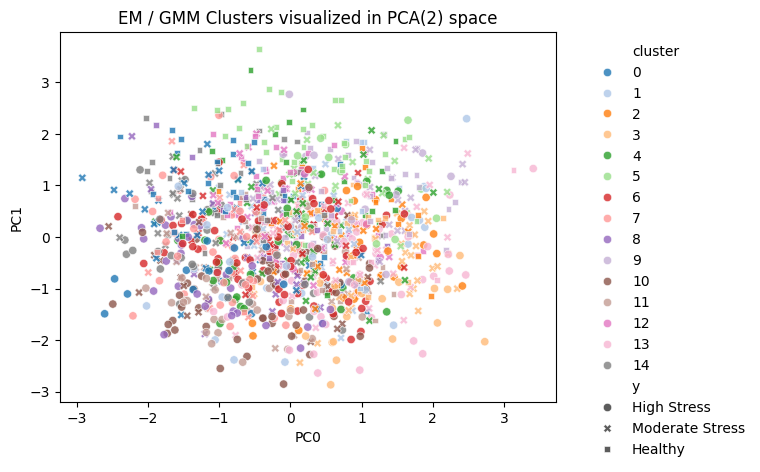

In [11]:
points_em = pca_points.copy()
points_em["cluster"] = cluster_labels
points_em["y"] = labels.values.ravel()

sns.scatterplot(
    data=points_em,
    x="PC0",
    y="PC1",
    hue="cluster",
    style="y",
    palette="tab20",
    alpha=0.8,
)
plt.title("EM / GMM Clusters visualized in PCA(2) space")
plt.legend(bbox_to_anchor=(1.05, 1), frameon=False)
plt.show()

## Conclusion
Overall, even with our high cluster probabilities, the visualization in PCA space shows substantial overlap between the clusters, and also between the plant stress labels. This indicates that the dataset does not form clearly separable groups when projects onto the first two principal components.

This is likely due to the nature of the data, coming from environmental sensor readings. These sensor readings tend to vary continuously, rather than form into clusters. Since PCA is a linear method, it also may not capture the nonlinear patterns that differentiate the plant stress levels.